# Прототип модели предсказания коэффицента восстановления золота из золотосодержащей руды

______

#### Данное исследование разделим на несколько частей.
______________________
### Часть 1: Подготовка данных
* [1. Изучение файлов с данными, получение общей информации, загрузка библиотек.](#1-bullet)
* [1. Проверка формулы вычисления эффективности обогащения, получение MAE.](#2-bullet)
* [2. Анализ признаков, недоступных в тестовой выборке.](#3-bullet)
* [3. Предобработка данных.](#4-bullet)
### Часть 2: Иссследовательский анализ
* [1. Исследование изменения концентрации элементов на каждом этапе.](#5-bullet)
* [2. Анализ распределения размеров гранул на обучающей и тестовой выборках.](#6-bullet)
* [3. Исследование суммарных концентраций веществ.](#7-bullet)
### Часть 3: построение и обучение моделей
* [1. Написание функции для вычисления итогового sMAPE.](#8-bullet)
* [2. Обучение и проверка нескольких моделей.](#9-bullet)
* [3. Поиск лучшей модели и её проверека на тестовой выборке.](#10-bullet)
____________________

####  Описание данных:

Технологический процесс

- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
- Xanthate **— ксантогенат (промотер, или активатор флотации);
- Sulphate — сульфат (на данном производстве сульфид натрия);
- Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота

Параметры этапов

- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи 

#### 1-bullet 
### Часть 1: Подготовка данных
1. Изучение файлов с данными, получение общей информации, загрузка библиотек.

In [1]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np
from numpy import inf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
#from sklearn.cross_validation import train_test_split
from sklearn.metrics.scorer import make_scorer

from numpy.random import RandomState
from scipy import stats as st


In [2]:
# открываем файлы с данными 
# и сохраняем в переменных
data_train = pd.read_csv('/datasets/gold_recovery_train.csv')
data_test = pd.read_csv('/datasets/gold_recovery_test.csv')
data_full = pd.read_csv('/datasets/gold_recovery_full.csv')

# создаем список объектов
datasets = [data_train, data_test, data_full]

In [3]:
def get_info(data):
    # получаем общую информацию 
    display(data.info())
    # выведем на экран сумму дубликатов
    print('Количество дубликатов:', data.duplicated().sum()) 
    # выводим на экран первые пять строк для 
    # зрительного ознакомления
    display(data.head())

In [4]:
# получим общую информацию по 1 таблице
# применив функцию
get_info(data_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

None

Количество дубликатов: 0


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [5]:
# получим общую информацию по 2 таблице
# применив функцию
get_info(data_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.in

None

Количество дубликатов: 0


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [6]:
# получим общую информацию по 3 таблице
# применив функцию
get_info(data_full)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant             

None

Количество дубликатов: 0


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


### Вывод
- загрузили необходимые библиотеки.
- открыли файлы и получили общую информацию по ним.
- все три таблицы имеют разную длину обучающая и полная выборки имеют равное количество столбцов, в тестовой таблице столбцов меньше. сумма длины обучающей и тестовой таблиц равна сумме длины полной таблицы.
- во всех таблицах имеются пропуски, дубликаты везде отсутстсвуют.
- кроме первого столбца, все таблицы имеют численный тип данных.

#### 2-bullet
### Часть 1: Подготовка данных
1. Проверка формулы вычисления эффективности обогащения, получение MAE.

In [7]:
# создадим функцию для расчета признака rougher.output.recovery
def find_mae(data):
    # найдем эффективность обогащения по формуле
    data['r.o.r_test'] = (data['rougher.output.concentrate_au'] *
                          (data['rougher.input.feed_au'] - 
                           data['rougher.output.tail_au']) / 
                          (data['rougher.input.feed_au'] * 
                           (data['rougher.output.concentrate_au'] - 
                            data['rougher.output.tail_au']))) * 100
    # удалим все строки, где есть пропуски, тк они будут мешать
    # рассчитывать MAE
    data.dropna(inplace=True)
    # найдем МАЕ и выведем на экран
    mae = mean_absolute_error(data['r.o.r_test'], data['rougher.output.recovery'])
    print('mae: %.3f' % (mae))

In [8]:
#  применим функцию
find_mae(data_train)

mae: 0.000


In [9]:
# поскольку были преобразования с обучающей таблицей
# откроем ее заново и сохраним в переменной
data_train = pd.read_csv('/datasets/gold_recovery_train.csv')

### Вывод
- рассчитали эффективность обогащения чернового концентрата при помощи функции
- удалили все пропуски и посчитали МАЕ.
- пришли к выводу, что расчет произведен абсолютно верно, т.к. наш расчет ничем не отличается от имеющегося, т.к. МАЕ=0.
- обучающую таблицу открыли и сохранили заново, чтобы преобразования в виде нового столбца и удаление пропусков не сказалось на дальнейшем исследовании.

#### 3-bullet
### Часть 1: Подготовка данных
2. Анализ признаков, недоступных в тестовой выборке.

In [10]:
# создадим функцию, которая удалит ненужные столбцы
def drop_final(data):
    data = data.drop(['final.output.concentrate_ag',
                      'final.output.concentrate_pb',
                      'final.output.concentrate_sol',
                      'final.output.concentrate_au',
                      'final.output.tail_ag',
                      'final.output.tail_pb',
                      'final.output.tail_sol',
                      'final.output.tail_au'], axis=1)

In [11]:
# применим функцию к тренировочной и полной таблицам
drop_final(data_full)
drop_final(data_train)

### Вывод

- в тестовой выборке полностью отсутствуют целевые признаки: эффективность обогащения чернового концентрата и финального концентрат.
- кроме того, в тестовой выборке также полностью отсутствуют признаки, характеризующие финальную стадию очистки.
- видимо это сделано в силу того, что финальные данные в силу технологического процесса появляются вместе с финальным целевым признаком (эффективностью финального обогащения).
- соответственно они нам не нужны, т.к их не будет при работе модели.

#### 4-bullet 
### Часть 1: Подготовка данных
3. Предобработка данных.

In [12]:
# создадим список таблиц
datasets = [data_train, data_full]

# создадим список, который будет
# перебирать элемены списка
for i in datasets:
    # приведем дату и время во всех таблицах к общему формату
    i['date'] = pd.to_datetime(i['date'], format='%Y-%m-%dT%H:%M:%S')
    # удалим все строки, где есть пропуски в целевых признаках
    i.dropna(subset=['rougher.output.recovery', 'final.output.recovery'], 
             inplace=True)
    # заполним пропуски, установив параметр метода заполнения 
    # предыдущим значеним
    i.fillna(method='backfill', axis=0, inplace=True)
    #i.dropna(inplace=True)
    # выведем информацию о таблице на экран    
    display(i.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14149 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  14149 non-null datetime64[ns]
final.output.concentrate_ag                           14149 non-null float64
final.output.concentrate_pb                           14149 non-null float64
final.output.concentrate_sol                          14149 non-null float64
final.output.concentrate_au                           14149 non-null float64
final.output.recovery                                 14149 non-null float64
final.output.tail_ag                                  14149 non-null float64
final.output.tail_pb                                  14149 non-null float64
final.output.tail_sol                                 14149 non-null float64
final.output.tail_au                                  14149 non-null float64
primary_cleaner.input.sulfate                         14149 non-null float64
primary_cleaner.input.depressant     

None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19439 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  19439 non-null datetime64[ns]
final.output.concentrate_ag                           19439 non-null float64
final.output.concentrate_pb                           19439 non-null float64
final.output.concentrate_sol                          19439 non-null float64
final.output.concentrate_au                           19439 non-null float64
final.output.recovery                                 19439 non-null float64
final.output.tail_ag                                  19439 non-null float64
final.output.tail_pb                                  19439 non-null float64
final.output.tail_sol                                 19439 non-null float64
final.output.tail_au                                  19439 non-null float64
primary_cleaner.input.sulfate                         19439 non-null float64
primary_cleaner.input.depressant     

None

In [13]:
# приведем дату и время к общему формату
data_test['date'] = pd.to_datetime(data_test['date'], 
                                   format='%Y-%m-%dT%H:%M:%S')
# заполним пропуски, установив параметр метода заполнения 
# предыдущим значеним
data_test.fillna(method='backfill', axis=0, inplace=True)
# выведем информацию о таблице на экран    
display(data_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null datetime64[ns]
primary_cleaner.input.sulfate                 5856 non-null float64
primary_cleaner.input.depressant              5856 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5856 non-null float64
primary_cleaner.state.floatbank8_a_air        5856 non-null float64
primary_cleaner.state.floatbank8_a_level      5856 non-null float64
primary_cleaner.state.floatbank8_b_air        5856 non-null float64
primary_cleaner.state.floatbank8_b_level      5856 non-null float64
primary_cleaner.state.floatbank8_c_air        5856 non-null float64
primary_cleaner.state.floatbank8_c_level      5856 non-null float64
primary_cleaner.state.floatbank8_d_air        5856 non-null float64
primary_cleaner.state.floatbank8_d_level      5856 non-null float64
ro

None

### Вывод

- во всех таблицах удалили строки с пропусками в целевых признаках.
- во всех таблицах пропуски в признаках заменили ближайшими вышестоящими значениями, воспользовавшись методом backfill.
- во всех таблицах дату привели к общему формату времени.

#### 5-bullet 
### Часть 2: Иссследовательский анализ
1. Исследование изменения концентрации элементов на каждом этапе.

In [14]:
# создадим таблицу со средними значениями
# обучающей выборки
concentrate = data_train.mean()
# создадим словарь, где ключами будут
# искомые металы, а значениями концентрация
# этих металлов на разных стадиях
concentrate = {'au':[concentrate['rougher.output.concentrate_au'], concentrate['primary_cleaner.output.concentrate_au'], 
                    concentrate['secondary_cleaner.output.tail_au'], concentrate['final.output.concentrate_au']],
               'ag':[concentrate['rougher.output.concentrate_ag'], concentrate['primary_cleaner.output.concentrate_ag'], 
                    concentrate['secondary_cleaner.output.tail_ag'], concentrate['final.output.concentrate_ag']],
               'pb':[concentrate['rougher.output.concentrate_pb'], concentrate['primary_cleaner.output.concentrate_pb'], 
                    concentrate['secondary_cleaner.output.tail_pb'], concentrate['final.output.concentrate_pb']]}
# создадим датафрейм и выведем на экран
concentrate = pd.DataFrame(concentrate)
display(concentrate)

,au,ag,pb
0,19.439958,11.775812,7.664555
1,32.386836,8.200916,9.568457
2,4.246961,14.281119,5.847228
3,44.003792,5.141915,10.132841


### Вывод
- создали таблицу со средними значениями столбцов обучающей таблицы.
- создали словарь, где искомые металлы являются ключами, а значениями являются столбцы с концентрацией этих металлов на каждой стадии (флотация, 1, 2 очистики и финальная стадия.)
- сделали из словаря датафрейм и вывели на экран.
- видим, что средняя концентрация золота возрастает на каждой стадии, кроме вторичной очистки.
- концентрация других металлов от стадии к стадии плавает.

#### 6-bullet 
### Часть 2: Иссследовательский анализ
2. Анализ распределения размеров гранул на обучающей и тестовой выборках.


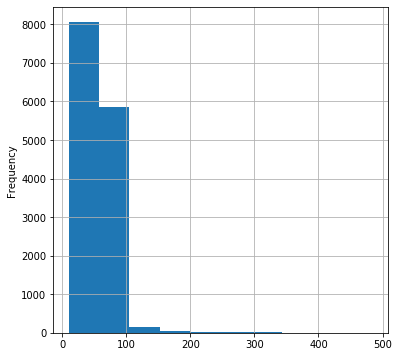

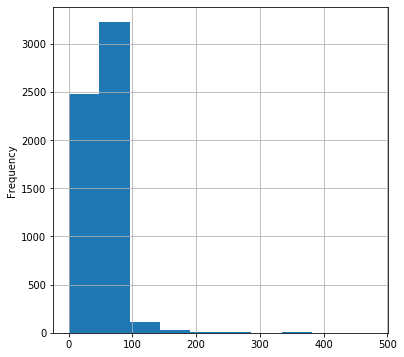

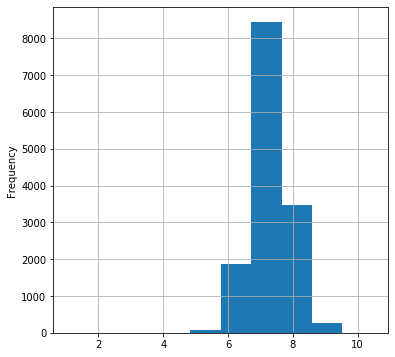

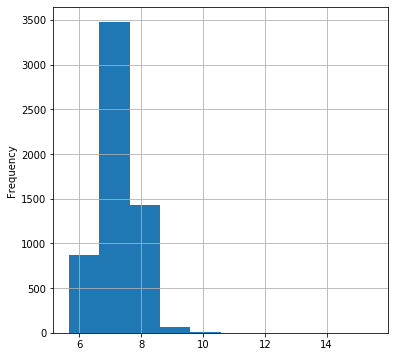

In [15]:
#составим список названий колонок, к которым применим метод plot()
hist_list = [data_train['rougher.input.feed_size'], 
             data_test['rougher.input.feed_size'], 
             data_train['primary_cleaner.input.feed_size'], 
             data_test['primary_cleaner.input.feed_size']] 

#зададим цикл, который будет перебирать каждый элелемент из списка колонок
for i in hist_list: 
    #построим гистограммыи
    #boxplot(i)
    i.plot(kind='hist', grid=True, figsize=(6,6))
    plt.show()  

### Вывод
- построили графики распределения размеров гранул сырья на обучающей и тестовой выборках.
- пришли к выводу, что распределения похожи на нормальное распределение и схожи между собой, т.е. отличаются не сильно, только в распредлении черновго концентрата имеется небольшое смещение в меньшую сторону в обучающей таблице и небольшое смещение в большую сторону в тестовой таблице. 
- на стадии очистки распределения имеют еще большую схожесть, только в тестовой таблице, чуть больше хвостов.
- с такими данными работать можно.

#### 7-bullet
### Часть 2: Иссследовательский анализ
3. Исследование суммарных концентраций веществ.

In [16]:
# создадим функцию которая в отдельных столбцах
# будет иметь концентрацию всех веществ на каждой стадии
def get_all_subst(data):
    data['primary_cleaner.state.floatbank8_all'] = (data['primary_cleaner.state.floatbank8_a_air'] +
                                                    data['primary_cleaner.state.floatbank8_a_level'] +
                                                    data['primary_cleaner.state.floatbank8_b_air'] +
                                                    data['primary_cleaner.state.floatbank8_b_level'] +
                                                    data['primary_cleaner.state.floatbank8_c_air'] +
                                                    data['primary_cleaner.state.floatbank8_c_level'] +
                                                    data['primary_cleaner.state.floatbank8_d_air'] +
                                                    data['primary_cleaner.state.floatbank8_d_level'])
                                                
    data['rougher.state.floatbank10_all'] = (data['rougher.state.floatbank10_a_air'] +
                                             data['rougher.state.floatbank10_a_level'] +
                                             data['rougher.state.floatbank10_b_air'] +
                                             data['rougher.state.floatbank10_b_level'] +
                                             data['rougher.state.floatbank10_c_air'] +
                                             data['rougher.state.floatbank10_c_level'] +
                                             data['rougher.state.floatbank10_d_air'] +
                                             data['rougher.state.floatbank10_d_level'] +
                                             data['rougher.state.floatbank10_e_air'] +
                                             data['rougher.state.floatbank10_e_level'] +
                                             data['rougher.state.floatbank10_f_air'] +
                                             data['rougher.state.floatbank10_f_level'])
                                 
    data['secondary_cleaner.state.floatbank2_all'] = (data['secondary_cleaner.state.floatbank2_a_air'] +
                                                      data['secondary_cleaner.state.floatbank2_a_level'] +
                                                      data['secondary_cleaner.state.floatbank2_b_air'] +
                                                      data['secondary_cleaner.state.floatbank2_b_level'] +
                                                      data['secondary_cleaner.state.floatbank3_a_air'] +
                                                      data['secondary_cleaner.state.floatbank3_a_level'] +
                                                      data['secondary_cleaner.state.floatbank3_b_air'] +
                                                      data['secondary_cleaner.state.floatbank3_b_level'] +
                                                      data['secondary_cleaner.state.floatbank4_a_air'] +
                                                      data['secondary_cleaner.state.floatbank4_a_level'] +
                                                      data['secondary_cleaner.state.floatbank4_b_air'] +
                                                      data['secondary_cleaner.state.floatbank4_b_level'] +
                                                      data['secondary_cleaner.state.floatbank5_a_air'] +
                                                      data['secondary_cleaner.state.floatbank5_a_level'] +
                                                      data['secondary_cleaner.state.floatbank5_b_air'] +
                                                      data['secondary_cleaner.state.floatbank5_b_level'] +
                                                      data['secondary_cleaner.state.floatbank6_a_air'] +
                                                      data['secondary_cleaner.state.floatbank6_a_level'])
    # построим диаграмы размаха для суммы концентрации
    # веществ на каждой стадии 
    data.boxplot('rougher.state.floatbank10_all')
    plt.show()
    data.boxplot('primary_cleaner.state.floatbank8_all')
    plt.show()
    data.boxplot('secondary_cleaner.state.floatbank2_all')
    plt.show()

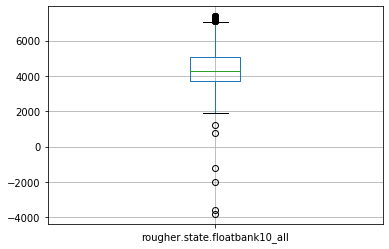

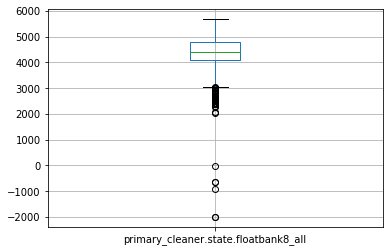

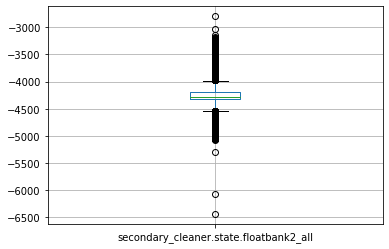

In [17]:
# применим функцию для тренировочной таблицы
get_all_subst(data_train)

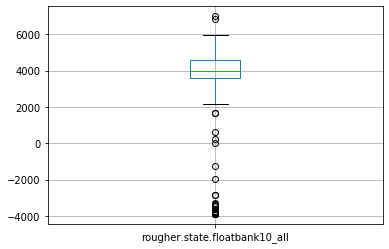

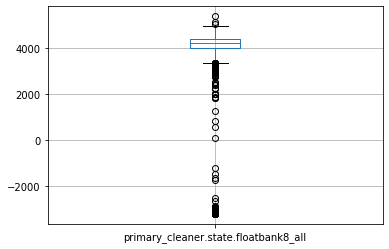

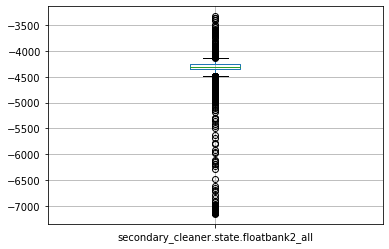

In [18]:
# применим функцию для тестовой таблицы
get_all_subst(data_test)

In [19]:
# удалим вновь созданные столбцы
data_train = data_train.drop(['rougher.state.floatbank10_all', 
                      'primary_cleaner.state.floatbank8_all', 
                      'secondary_cleaner.state.floatbank2_all'],
                       axis=1)

In [20]:
# удалим вновь созданные столбцы
data_test = data_test.drop(['rougher.state.floatbank10_all', 
                      'primary_cleaner.state.floatbank8_all', 
                      'secondary_cleaner.state.floatbank2_all'],
                       axis=1)

In [21]:
# создадим список таблиц
datas_list = [data_train, data_test, data_full]

# создадим список, который будет перебирать
# элемены списка и удалять строки с нулевыми значениями
for i in datas_list:
    i = i[(i != 0).all(axis=1)] 
    print(i.shape)

(12918, 87)
(5470, 53)
(17873, 87)


### Вывод:
- постоив диаграммы рассеивания, увидели, что в обехи таблицах имеются выборсы (и на каждой стадии), при этом сами ящики, среднее и границы квантилей похожи.
- поскольку выбросы могут содержать какие-либо закономерности, не знаю что с ними делать, поробуем оставить так и построить модели, проверив на метрике качества (при плохих показателях необходимо будет вернуться и подумать что делать).

#### 8-bullet 
### Часть 3: построение и обучение моделей
1. Написание функции для вычисления итогового sMAPE.

In [22]:
# создадим функцию, которая на вход принимает правильные 
# ответы и предсказания, а выдает искому метрику
def smape(answer, predict):
    return (1/len(answer) * np.sum(2 * np.abs(predict-answer) / 
                                   (np.abs(answer) + np.abs(predict))*100))

# обернем функцию в make_scorer(), чтобы ее использовать
# в качестве параметра при кросс-валидации
smape_scorer = make_scorer(smape, greater_is_better=False)

### Вывод:
- написали функцию, которая будет вычислять искомую метрику sMAPE.

#### 9-bullet
### Часть 3: построение и обучение моделей
2. Обучение и проверка нескольких моделей.

сохраним целевые признаки и признаки в переменных.

In [23]:
# получим целевые признаки на тренировочной таблице
target_rog = data_train['rougher.output.recovery']
target_fin = data_train['final.output.recovery']
# получим признаки на тренировочной таблице
features = data_train.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)

обучим модель линейная регрессия и найдем лучшую при помощи кросс-валидации.

In [24]:
model = LinearRegression()
cross = cross_val_score(model, features, 
                        target_rog, cv=5,
                        scoring=smape_scorer)
result = cross.sum()/len(cross)*(-1)
print('Лучшее значение метрики для rougher:', result)

Лучшее значение метрики для rougher: 9.383234495855367


In [25]:
model = LinearRegression()
cross = cross_val_score(model, features, 
                        target_fin, cv=5,
                        scoring=smape_scorer)
result = cross.sum()/len(cross)*(-1)
print('Лучшее значение метрики для final:', result)

Лучшее значение метрики для final: 5.558985835437739


обучим модель решающее дерево и найдем лучшую при помощи кросс-валидации.

In [26]:
best_result_forest = 100
best_depth_forest = 0

for depth in range (1, 21):
        model = DecisionTreeRegressor(random_state=12345, 
                                      max_depth=depth) 
        model_smape =cross_val_score(model, 
                                     features, 
                                     target_rog, 
                                     cv=4,
                                     scoring=smape_scorer)
        result = model_smape.sum()/len(model_smape)*(-1) 

        if result < best_result_forest:
                best_result_forest = result
                best_depth_forest = depth

print('Лучшее значение метрики для rougher:', best_result_forest, 
      'Глубина:', best_depth_forest)

Лучшее значение метрики для rougher: 2.2036276640753725 Глубина: 13


In [27]:
best_result_forest = 100
best_depth_forest = 0

for depth in range (1, 21):
        model = DecisionTreeRegressor(random_state=12345, 
                                      max_depth=depth) 
        model_smape =cross_val_score(model, 
                                     features, 
                                     target_fin, 
                                     cv=4,
                                     scoring=smape_scorer)
        result = model_smape.sum()/len(model_smape)*(-1) 

        if result < best_result_forest:
                best_result_forest = result
                best_depth_forest = depth

print('Лучшее значение метрики для final:', best_result_forest, 
      'Глубина:', best_depth_forest)

Лучшее значение метрики для final: 3.1131694683251974 Глубина: 17


обучим модель случайный лес и найдем лучшую при помощи кросс-валидации.

In [28]:
best_result_forest = 100
best_depth_forest = 0
best_est_forest = 0

for est in range(5, 21, 10):
    for depth in range (1, 21):
            model = RandomForestRegressor(random_state=12345 , 
                                          n_estimators=est , 
                                          max_depth=depth) 
            model_smape =cross_val_score(model, 
                                  features, 
                                  target_rog, 
                                  cv=4,
                                  scoring=smape_scorer)
            result = model_smape.sum()/len(model_smape)*(-1) 

            if result < best_result_forest:
                best_est_forest = est
                best_result_forest = result
                best_depth_forest = depth

print('Лучшее значение метрики для rougher:', best_result_forest, 
      'Глубина:', best_depth_forest, 
      'Количество деревьев:', best_est_forest)

Лучшее значение метрики для rougher: 1.4365985545802227 Глубина: 19 Количество деревьев: 15


In [29]:
best_result_forest = 100
best_depth_forest = 0
best_est_forest = 0

for est in range(5, 21, 10):
    for depth in range (1, 21):
            model = RandomForestRegressor(random_state=12345 , 
                                          n_estimators=est , 
                                          max_depth=depth) 
            model_smape =cross_val_score(model, 
                                  features, 
                                  target_fin, 
                                  cv=4,
                                  scoring=smape_scorer)
            result = model_smape.sum()/len(model_smape)*(-1) 

            if result < best_result_forest:
                best_est_forest = est
                best_result_forest = result
                best_depth_forest = depth

print('Лучшее значение метрики для final:', best_result_forest, 
      'Глубина:', best_depth_forest, 
      'Количество деревьев:', best_est_forest)

Лучшее значение метрики для final: 2.855708739195844 Глубина: 18 Количество деревьев: 15


### Вывод:
- пришли к выводу, что лучшие значения искомой метрики получаются на модели случайный лес.
- также видим, что для каждого целевого признака необходимо подбирать свои гиперпараметры, т.к. искомая метрика меняется в зависимости от обучения/предсказания каждого целевого признака при чем в разные стороны (то модель лучше предсказывает первый целевой признак, то второй).

#### 10-bullet
### Часть 3: построение и обучение моделей
3. Поиск лучшей модели и её проверека на тестовой выборке.

In [30]:
# сохраним признаки в тренировочной таблице для обучения так, 
# чтобы они совпадали с признаками из тестовой таблицы для равного количества признаков
features = data_train[['primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
                       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
                       'primary_cleaner.state.floatbank8_a_air', 'primary_cleaner.state.floatbank8_a_level',
                       'primary_cleaner.state.floatbank8_b_air', 'primary_cleaner.state.floatbank8_b_level',
                       'primary_cleaner.state.floatbank8_c_air', 'primary_cleaner.state.floatbank8_c_level',
                       'primary_cleaner.state.floatbank8_d_air', 'primary_cleaner.state.floatbank8_d_level',
                       'rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_rate',
                       'rougher.input.feed_size', 'rougher.input.feed_sol', 'rougher.input.feed_au', 
                       'rougher.input.floatbank10_sulfate', 'rougher.input.floatbank10_xanthate',
                       'rougher.input.floatbank11_sulfate', 'rougher.input.floatbank11_xanthate',
                       'rougher.state.floatbank10_a_air', 'rougher.state.floatbank10_a_level',
                       'rougher.state.floatbank10_b_air', 'rougher.state.floatbank10_b_level',
                       'rougher.state.floatbank10_c_air', 'rougher.state.floatbank10_c_level',
                       'rougher.state.floatbank10_d_air', 'rougher.state.floatbank10_d_level',
                       'rougher.state.floatbank10_e_air', 'rougher.state.floatbank10_e_level',
                       'rougher.state.floatbank10_f_air', 'rougher.state.floatbank10_f_level',
                       'secondary_cleaner.state.floatbank2_a_air', 'secondary_cleaner.state.floatbank2_a_level',
                       'secondary_cleaner.state.floatbank2_b_air', 'secondary_cleaner.state.floatbank2_b_level',
                       'secondary_cleaner.state.floatbank3_a_air', 'secondary_cleaner.state.floatbank3_a_level',
                       'secondary_cleaner.state.floatbank3_b_air', 'secondary_cleaner.state.floatbank3_b_level',
                       'secondary_cleaner.state.floatbank4_a_air', 'secondary_cleaner.state.floatbank4_a_level',
                       'secondary_cleaner.state.floatbank4_b_air', 'secondary_cleaner.state.floatbank4_b_level',
                       'secondary_cleaner.state.floatbank5_a_air', 'secondary_cleaner.state.floatbank5_a_level',
                       'secondary_cleaner.state.floatbank5_b_air', 'secondary_cleaner.state.floatbank5_b_level',
                       'secondary_cleaner.state.floatbank6_a_air', 'secondary_cleaner.state.floatbank6_a_level']]

присоединим к тестовой таблице целевые признаки из полной таблицы.

In [31]:
# добавим столбцы целевых признаков в тестовую таблицу
data_test['rougher.output.recovery'] = data_full['rougher.output.recovery'][:12403]
data_test['final.output.recovery'] = data_full['final.output.recovery'][:12403]

# получим признаки и целевые признаки в тестовой таблице
target_test_rog = data_test['rougher.output.recovery']
target_test_fin = data_test['final.output.recovery']
features_test = data_test.drop(['date', 'rougher.output.recovery', 
                                'final.output.recovery'], axis=1)

In [32]:
# создадим функцию, которая будет обучать модель и получать предсказания
def model_predict (features, target, 
                   features_test, target_test):
    # построим модель и обучим
    model = RandomForestRegressor(random_state=12345, 
                                  n_estimators=15, 
                                  max_depth=18)
    model.fit(features, target)
    # получим предсказания 
    predictions_test = model.predict(features_test)
    predictions_test = pd.Series(predictions_test)
    return predictions_test

In [33]:
# применим функцию и сохраним предсказания по черновому концентрату
predictions_rougher = model_predict(features, 
                                    target_rog, 
                                    features_test, 
                                    target_test_rog)
# выведем на экран среднее
display(predictions_rougher.mean())

77.48760371979805

In [34]:
# применим функцию и сохраним предсказания по финальному концентрату
predictions_final = model_predict(features, 
                                  target_fin, 
                                  features_test, 
                                  target_test_fin)
# выведем на экран среднее
display(predictions_final.mean())

65.62778229670185

In [35]:
# найдем итоговое значение метрики smape для целевых признаков
total = ((0.25*smape(target_test_rog, predictions_rougher)) +
         (0.75*smape(target_test_fin, predictions_final)))

print('Итоговое значение метрики smape', total)

Итоговое значение метрики smape 13.70236926614655


проверим модель на адекватность относительно константной.

In [36]:
# создадим серию предсказаний, содержащих одинаковое значение (среднее)
# для обоих целевых признаков
predictions_rougher_constant = pd.Series(target_rog.mean(), index = predictions_rougher.index)
predictions_final_constant = pd.Series(target_fin.mean(), index = predictions_final.index)

In [37]:
# найдем итоговое значение метрики smape для константной модели
total_constant = ((0.25*smape(target_test_rog, predictions_rougher_constant)) +
         (0.75*smape(target_test_fin, predictions_final_constant)))

print('Итоговое значение метрики smape для константной модели', total_constant)

Итоговое значение метрики smape 9.528180827428105


### Вывод:
- получили итоговое значение метрики smape 
- проверили модель на адекватность: получили значение метрики для константной модели ниже, чем на предсказаниях по тестовым данным. Выходит модель предсказывает хуже, чем если бы предсказывала просто среднее значение. 